In [3]:
import sys
sys.path.append('../scripts/')

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from dataclasses import dataclass
from sklearn.mixture import GaussianMixture

from xmm_transforms import PN_config, M1_config, M2_config, data_transformation_PN, data_transformation_MOS
from fits_extractor import extraction_photons, get_gti_from_file
from variability_utils import variability_computation
from logger import logger

In [5]:
@dataclass
class Args:
    path: str
    out: str
    bs: int
    dl: float
    tw: float
    gtr: float
    mta: int
    creator: str
    obs: str
    inst: str
    render: bool
    ds9: bool
    novar: bool
    evts: str
    gti: str
    img: str

# Example usage:
args = Args(
    path="../example/0001730201/",
    out="../data/",
    bs=3,
    dl=10,
    tw=100.0,
    gtr=1.0,
    mta=8,
    creator="nkhan",
    obs="0001730201",
    inst="PN",
    render=False,
    ds9=False,
    novar=False,
    evts="../example/0001730201/PN_clean.fits",
    gti="../example/0001730201/PN_gti.fits",
    img="../example/0001730201/PN_image.fits"
)

In [15]:
evt_file_PN = '../example/0001730201/PN_clean.fits'
evt_file_M1 = '../example/0001730201/M1_clean.fits'
evt_file_M2 = '../example/0001730201/M2_clean.fits'
evt_files = [evt_file_PN, evt_file_M1, evt_file_M2]
evt_file = evt_files[0]

data, header = extraction_photons(evt_file)
gti_list    = get_gti_from_file(args.gti)
t0_observation = min([evt["TIME"] for ccd in data for evt in ccd])
tf_observation = max([evt["TIME"] for ccd in data for evt in ccd])

2023-12-04 14:12:31,526 - DEBUG - fits_extractor.py:extraction_photons - calling extraction_photons()
2023-12-04 14:12:31,527 - DEBUG - fits_extractor.py:extraction_photons - events_file=../example/0001730201/PN_clean.fits
2023-12-04 14:12:31,568 - DEBUG - fits_extractor.py:get_gti_from_file - Getting GTIs from file=../example/0001730201/PN_gti.fits


In [16]:
tab = Table.read(evt_file, hdu=1)

2023-12-04 14:12:32,363 - WARNING - logger.py:_showwarning - UnitsWarning: '0.05 arcsec' did not parse as fits unit: Numeric factor not supported by FITS If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-12-04 14:12:32,369 - WARNING - logger.py:_showwarning - UnitsWarning: 'channel' did not parse as fits unit: At col 0, Unit 'channel' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


In [129]:
CCD_NUMBER = 3
# Variability Computation for 1 CCD
v = variability_computation(gti=gti_list,
                            time_interval=args.tw,
                            acceptable_ratio=args.gtr,
                            start_time=t0_observation,
                            end_time=tf_observation,
                            inst=args.inst,
                            box_size=args.bs,
                            data=data[CCD_NUMBER])

2023-12-04 16:03:12,004 - DEBUG - variability_utils.py:variability_computation - Calling variability_computation()...
2023-12-04 16:03:12,010 - DEBUG - variability_utils.py:variability_computation - gti: [(1.00532388e+08, 1.00533588e+08) (1.00533688e+08, 1.00537888e+08)
 (1.00537988e+08, 1.00538688e+08) (1.00538888e+08, 1.00538988e+08)
 (1.00543488e+08, 1.00543588e+08) (1.00544188e+08, 1.00544288e+08)
 (1.00544688e+08, 1.00544788e+08) (1.00544988e+08, 1.00548088e+08)
 (1.00548188e+08, 1.00548988e+08) (1.00549088e+08, 1.00555188e+08)]
2023-12-04 16:03:12,011 - DEBUG - variability_utils.py:variability_computation - time_interval: 100.0
2023-12-04 16:03:12,012 - DEBUG - variability_utils.py:variability_computation - acceptable_ratio: 1.0
2023-12-04 16:03:12,013 - DEBUG - variability_utils.py:variability_computation - start_time: 100532388.34954765
2023-12-04 16:03:12,014 - DEBUG - variability_utils.py:variability_computation - end_time:100555147.36131173
2023-12-04 16:03:12,017 - DEBUG - 

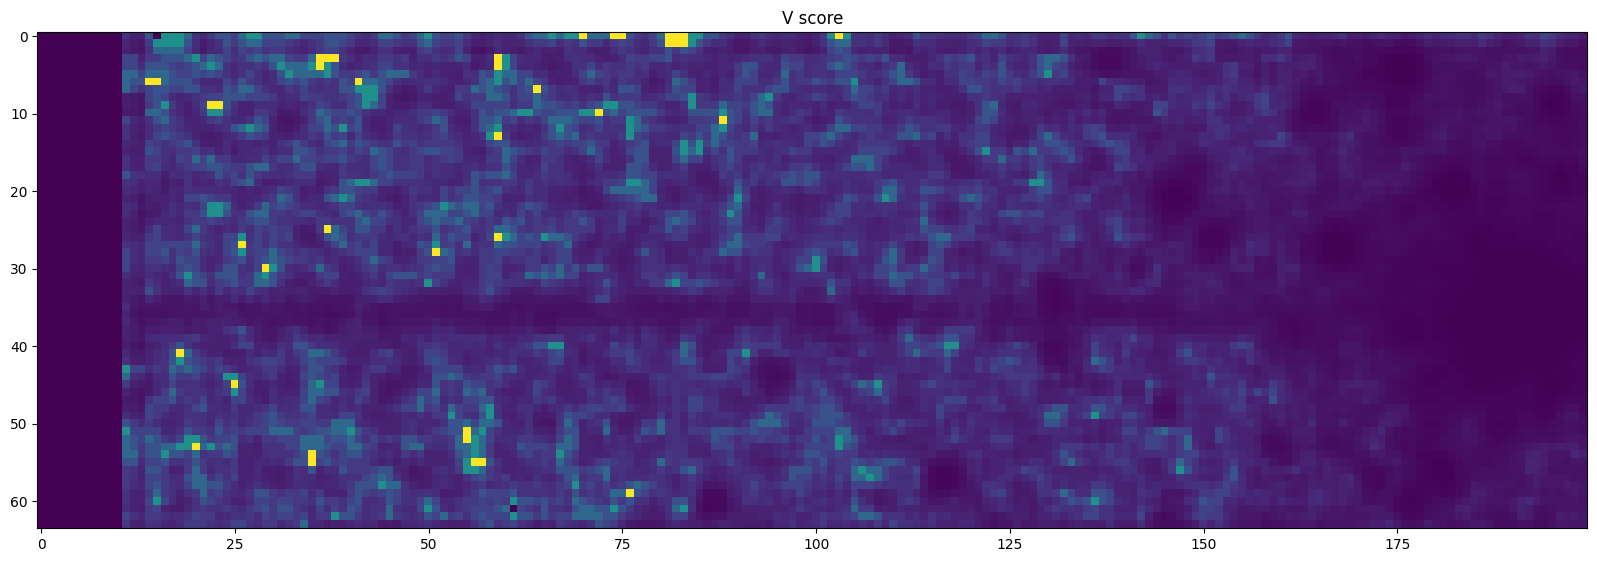

In [130]:
plt.figure(figsize=(20,10))
plt.title('V score')
plt.imshow(v, interpolation='none')
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


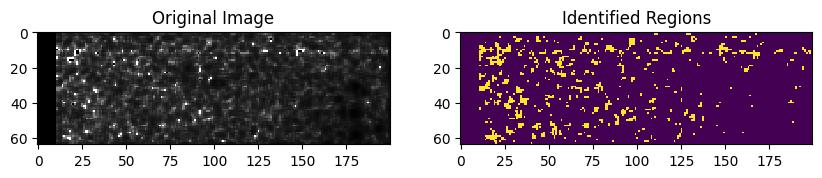

<Figure size 1000x500 with 0 Axes>

In [125]:
image_data = v.flatten().reshape(-1, 1)

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)  # You can adjust the number of components
gmm.fit(image_data)

# Get the predicted labels
labels = gmm.predict(image_data)


# Reshape labels to the original image shape
labels = labels.reshape(v.shape)
print(labels)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.figure(figsize=(10, 5))
ax[0].set_title('Original Image')
ax[0].imshow(v, cmap='gray', interpolation='none')
ax[1].set_title('Identified Regions')
ax[1].imshow(labels, cmap='viridis', interpolation='none')
plt.show()


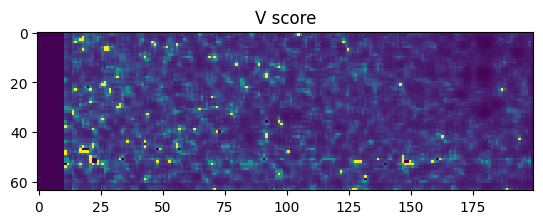

In [123]:
plt.title('V score')
plt.imshow(data_v2, interpolation='none')
plt.show()

In [ ]:
    data_v = []

    # XMM-Newton EPIC-pn CCD arrangement
    ccds = [[8, 7, 6, 9, 10, 11], [5, 4, 3, 0, 1, 2]]

    # Building data matrix
    for c in ccds[0]:
        data_v.extend(np.flipud(data_matrix[c]))
    i = 0
    for c in ccds[1]:
        m = np.flip(data_matrix[c])
        for j in range(64):
            data_v[i] = np.append(data_v[i], m[63 - j])
            i += 1

In [39]:
data_v  = PN_config(v)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1200,) + inhomogeneous part.

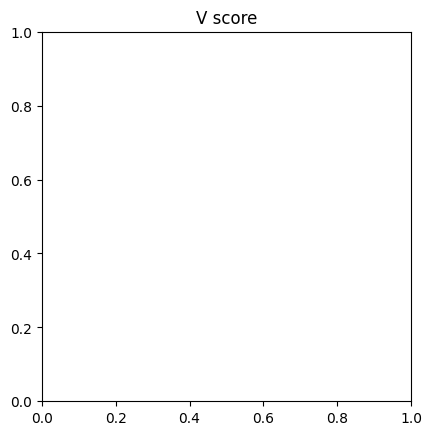

In [35]:
plt.title('V score')
plt.imshow(data_v)
plt.show()

In [27]:
def PN_window_cut(header, data_v):
    submode = header["SUBMODE"]
    data_v  = PN_config(v_matrix)
    if submode == "PrimeLargeWindow":
        return data_v[:, 100:300]
    elif submode == "PrimeSmallWindow":
        return data_v[128:192, 200:264]
    return data_v



In [29]:
PN_window_cut(header, v)

NameError: name 'v_matrix' is not defined

In [ ]:
data_v = np.array(data_v)

# Checking data mode acquisition
submode = header["SUBMODE"]

# Applying CCD and Mode configuration
if args.inst == "PN":
    data_v = PN_config(v_matrix)
    if submode == "PrimeLargeWindow":
        data_vm = data_v[:, 100:300]
    elif submode == "PrimeSmallWindow":
        data_vm = data_v[128:192, 200:264]
    else:
        data_vm = data_v

In [ ]:
PN_config(data_matrix=)
M1_config(data_matrix=)
M2_config(data_matrix=)
data_transformation_PN(data=, header=)
data_transformation_MOS(data=, header=)

In [ ]:
?data_transformation_PN